In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance, ImageColor

In [2]:
ITEM_SIZE = (20, 20)

## Player

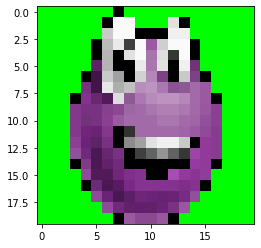

In [3]:
im_player = Image.open("Lazarus_stand.gif")
im_player.convert('P', palette=Image.ADAPTIVE, colors=6)
im_player = im_player.crop((0,2,38,40))
im_player = im_player.resize(ITEM_SIZE)
plt.imshow(im_player)

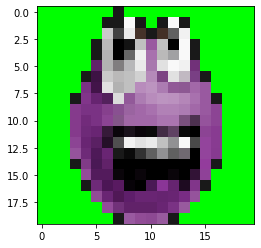

In [4]:
im_player_sq = Image.open("Lazarus_squished.gif")
im_player_sq.convert('P', palette=Image.ADAPTIVE, colors=6)
im_player_sq = im_player_sq.crop((0,2,38,40))
im_player_sq = im_player_sq.resize(ITEM_SIZE)
plt.imshow(im_player_sq)

## Wall

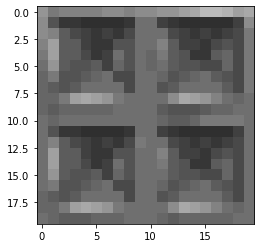

In [5]:
im_wall = Image.open("Wall.gif")
im_wall = im_wall.convert('P', palette=Image.ADAPTIVE, colors=6)
im_wall = im_wall.crop((1,1,39,39))
im_wall = im_wall.resize(ITEM_SIZE)

plt.imshow(im_wall)

## Boxes

In [51]:
def get_box(file_name: str):
    im = Image.open(file_name)
    im = im.convert('P', palette=Image.ADAPTIVE, colors=6)
    im = im.crop((1,1,39,39))
    im = im.resize(ITEM_SIZE)
    
    return im

def set_color_to_green(im, color: str):
    index = im.palette.getcolor(ImageColor.getrgb(color))
    palette = im.palette.getdata()
    palette_type, palette_data = palette[0], bytearray(palette[1])
    
    # change color at index
    palette_data[index:index + 3] = b'\x00\xff\x00'
    
    return im.putpalette(palette_data)

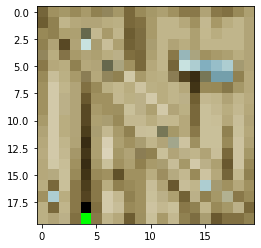

In [7]:
im_wood = get_box("WoodBox.gif")
plt.imshow(im_wood)

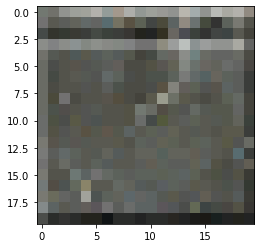

In [8]:
im_stone = get_box("StoneBox.gif")
plt.imshow(im_stone)

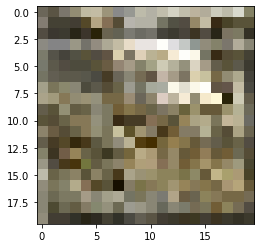

In [9]:
im_rock = get_box("Rock.gif")
plt.imshow(im_rock)

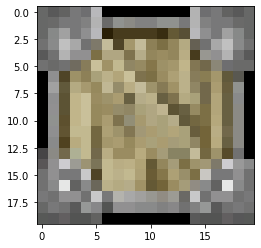

In [10]:
im_metal = get_box("MetalBox.gif")
set_color_to_green(im_metal, "#000")
plt.imshow(im_metal)

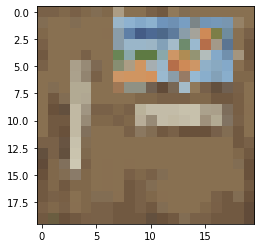

In [11]:
im_card = get_box("CardBox.gif")
plt.imshow(im_card)

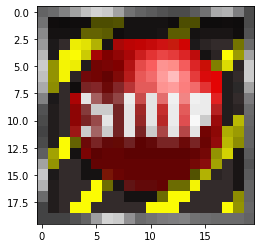

In [12]:
im_btn = get_box("Button.gif")
plt.imshow(im_btn)